<a href="https://colab.research.google.com/github/rosie0520486/superstore/blob/main/zemi0508.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
file_path = '/content/drive/MyDrive/patentclean.csv'
drive.mount('/content/drive')
import pandas as pd
df = pd.read_csv(file_path)

# cross-domain 여부 계산 (서로 다른 CPC prefix 2개 이상이면 True)
def is_cross_domain(cpc_string):
    if pd.isna(cpc_string):
        return 0
    codes = str(cpc_string).split(';;')
    prefixes = set(code.strip()[:4] for code in codes if len(code.strip()) >= 4)
    return 1 if len(prefixes) > 1 else 0

df['cross_domain'] = df['CPC Classifications'].apply(is_cross_domain)

Mounted at /content/drive


In [ ]:
# 기업별 M&A 기준 연도가 이미 'M&Aperiod' 컬럼에 들어 있다고 가정
df['period'] = df.apply(lambda row: 'pre' if row['Publication Year'] < row['M&Aperiod'] else 'post', axis=1)

In [ ]:
summary = df.groupby(['group', 'period']).agg(
    count=('Lens ID', 'count'),
    avg_citation=('Cited by Patent Count', 'mean'),
    std_citation=('Cited by Patent Count', 'std'),
    cross_domain_rate=('cross_domain', 'mean')
).reset_index()

print(summary)

  group period  count  avg_citation  std_citation  cross_domain_rate
0     C   post   6244      1.806374     11.345342           0.651185
1     C    pre  36470     25.872141     86.172879           0.674609
2     T   post  16619      2.632288     18.289162           0.592274
3     T    pre  55652     53.908125    128.054069           0.514663


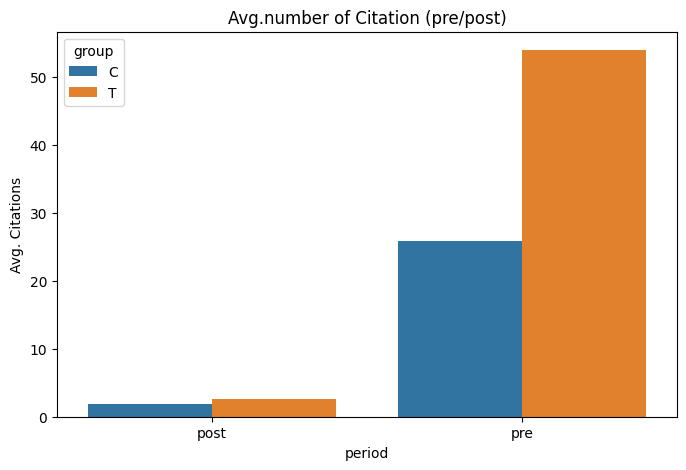

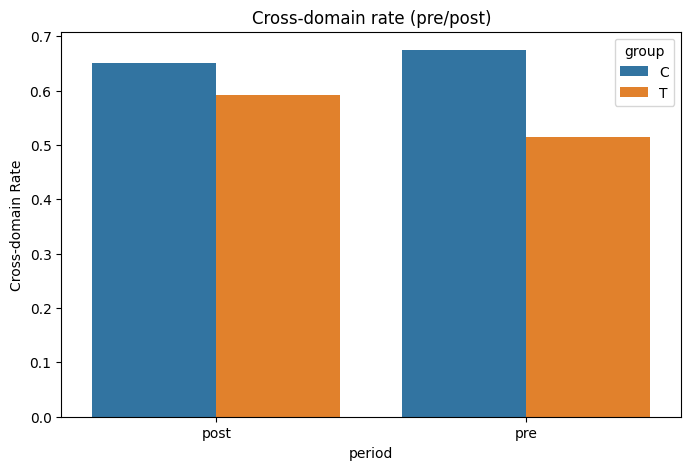

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 막대그래프: 인용 수
plt.figure(figsize=(8, 5))
sns.barplot(data=summary, x='period', y='avg_citation', hue='group')
plt.title("Avg.number of Citation (pre/post)")
plt.ylabel("Avg. Citations")
plt.show()

# 막대그래프: 타기술 인용률
plt.figure(figsize=(8, 5))
sns.barplot(data=summary, x='period', y='cross_domain_rate', hue='group')
plt.title("Cross-domain rate (pre/post)")
plt.ylabel("Cross-domain Rate")
plt.show()

In [ ]:
from scipy.stats import ttest_ind

# 예: 처치군 pre vs post
pre_t = df[(df['group'] == 'T') & (df['period'] == 'pre')]['Cited by Patent Count']
post_t = df[(df['group'] == 'T') & (df['period'] == 'post')]['Cited by Patent Count']

# Welch’s t-test (분산이 다를 수 있으므로)
t_stat, p_val = ttest_ind(pre_t, post_t, equal_var=False)
print("T-test (처치군 pre vs post):", t_stat, p_val)

T-test (처치군 pre vs post): 91.39266855810659 0.0


In [ ]:
summary['cv'] = summary['std_citation'] / summary['avg_citation']

In [ ]:
from scipy.stats import zscore

df['citation_z'] = df.groupby(['group'])['Cited by Patent Count'].transform(
    lambda x: zscore(x, ddof=1) if x.std() > 0 else 0
)

In [ ]:
# 평균 대비 얼마나 표준편차 위에 있는지 계산
summary['normalized_avg'] = summary['avg_citation'] / summary['std_citation']

In [ ]:
summary['normalized_mean'] = summary['avg_citation'] / summary['std_citation']
summary['cv'] = summary['std_citation'] / summary['avg_citation']

In [ ]:
# 그룹 × 시기별 요약 집계
summary = df.groupby(['group', 'period']).agg(
    count=('Lens ID', 'count'),
    avg_citation=('Cited by Patent Count', 'mean'),
    std_citation=('Cited by Patent Count', 'std'),
    cross_domain_rate=('cross_domain', 'mean')
).reset_index()

In [ ]:
# 평균 인용수를 표준편차로 정규화 (normalized mean)
summary['normalized_mean'] = summary['avg_citation'] / summary['std_citation']

# 변동계수 CV (표준편차 / 평균)
summary['cv'] = summary['std_citation'] / summary['avg_citation']

In [ ]:
from scipy.stats import zscore

# 각 group별 z-score 계산
df['citation_z'] = df.groupby('group')['Cited by Patent Count'].transform(
    lambda x: zscore(x, ddof=1) if x.std() > 0 else 0
)

In [ ]:
print("=== 요약 통계표 ===")
print(summary)

print("\n=== 예시: 정규화된 인용 수 (z-score) 상위 5개 특허 ===")
print(df[['Lens ID', 'group', 'period', 'Cited by Patent Count', 'citation_z']].sort_values(by='citation_z', ascending=False).head())

=== 요약 통계표 ===
  group period  count  avg_citation  std_citation  cross_domain_rate  \
0     C   post   6244      1.806374     11.345342           0.651185   
1     C    pre  36470     25.872141     86.172879           0.674609   
2     T   post  16619      2.632288     18.289162           0.592274   
3     T    pre  55652     53.908125    128.054069           0.514663   

   normalized_mean        cv  
0         0.159217  6.280727  
1         0.300235  3.330721  
2         0.143926  6.948008  
3         0.420979  2.375413  

=== 예시: 정규화된 인용 수 (z-score) 상위 5개 특허 ===
                   Lens ID group period  Cited by Patent Count  citation_z
91840  171-204-547-472-999     C    pre                   2881   35.645927
5464   128-391-775-777-855     T    pre                   2886   24.781440
49685  116-395-437-331-570     T    pre                   2859   24.546163
75061  190-048-788-835-823     C    pre                   1870   23.039247
76117  081-293-342-476-413     C    pre             

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-16-b350da0841d1>:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x="period", y="Cited by Patent Count", hue="group", ci="sd")


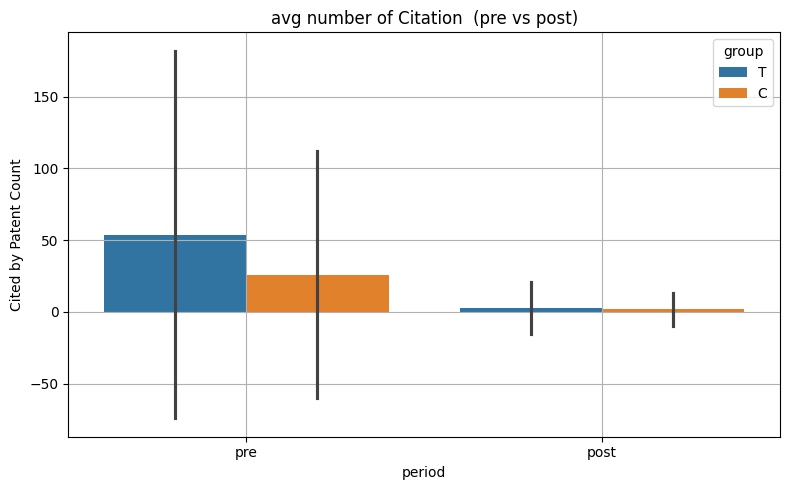

<ipython-input-16-b350da0841d1>:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="period", y="cross_domain", hue="group", ci=None)


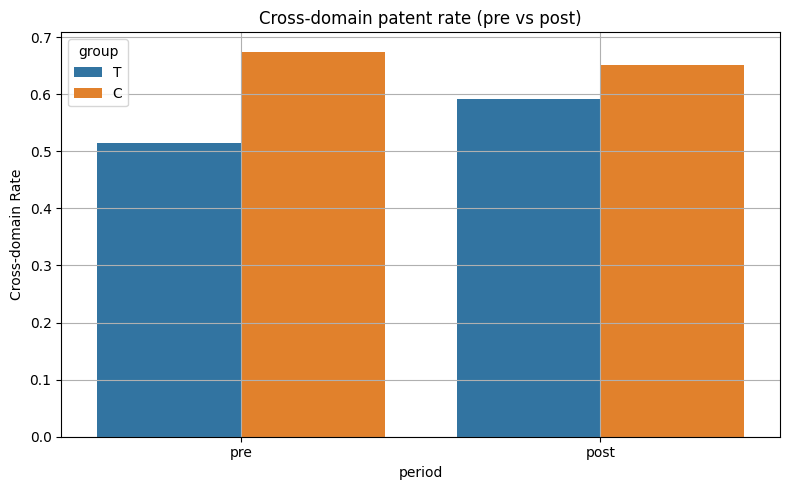

=== [통계검정 결과] ===
>> 처치군 (T) 평균 인용 수 변화:
  - T-test p-value: 0.0000
  - Mann-Whitney U-test p-value: 0.0000
  → 유의미한 변화 있음

>> 대조군 (C) 평균 인용 수 변화:
  - T-test p-value: 0.0000
  - Mann-Whitney U-test p-value: 0.0000
  → 유의미한 변화 있음


In [ ]:
# 1. 필수 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

# 2. 데이터 불러오기 및 전처리 (기존 분석 결과가 포함되어 있다고 가정)
from google.colab import drive
file_path = '/content/drive/MyDrive/patentclean.csv'
drive.mount('/content/drive')
import pandas as pd
df = pd.read_csv(file_path)
# cross-domain 계산
def is_cross_domain(cpc_string):
    if pd.isna(cpc_string):
        return 0
    codes = str(cpc_string).split(';;')
    prefixes = set(code.strip()[:4] for code in codes if len(code.strip()) >= 4)
    return 1 if len(prefixes) > 1 else 0

df['cross_domain'] = df['CPC Classifications'].apply(is_cross_domain)
df['period'] = df.apply(lambda row: 'pre' if row['Publication Year'] < row['M&Aperiod'] else 'post', axis=1)

# -----------------------------
# [1] 시각화
# -----------------------------

# 1-1. 평균 인용 수 시각화
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="period", y="Cited by Patent Count", hue="group", ci="sd")
plt.title("avg number of Citation  (pre vs post)")
plt.ylabel("Cited by Patent Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# 1-2. cross-domain 비율 시각화
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="period", y="cross_domain", hue="group", ci=None)
plt.title("Cross-domain patent rate (pre vs post)")
plt.ylabel("Cross-domain Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# [2] 통계 검정 (T-test + U-test)
# -----------------------------

# 처치군 T: pre vs post
pre_t = df[(df['group'] == 'T') & (df['period'] == 'pre')]['Cited by Patent Count']
post_t = df[(df['group'] == 'T') & (df['period'] == 'post')]['Cited by Patent Count']

# 대조군 C: pre vs post
pre_c = df[(df['group'] == 'C') & (df['period'] == 'pre')]['Cited by Patent Count']
post_c = df[(df['group'] == 'C') & (df['period'] == 'post')]['Cited by Patent Count']

# T-test (정규성 가정, 분산 다름)
t_stat_t, p_val_t = ttest_ind(pre_t, post_t, equal_var=False)
t_stat_c, p_val_c = ttest_ind(pre_c, post_c, equal_var=False)

# Mann-Whitney U-test (비모수)
u_stat_t, u_p_t = mannwhitneyu(pre_t, post_t, alternative='two-sided')
u_stat_c, u_p_c = mannwhitneyu(pre_c, post_c, alternative='two-sided')

# -----------------------------
# [3] 결과 출력
# -----------------------------

print("=== [통계검정 결과] ===")
print(">> 처치군 (T) 평균 인용 수 변화:")
print(f"  - T-test p-value: {p_val_t:.4f}")
print(f"  - Mann-Whitney U-test p-value: {u_p_t:.4f}")
print("  →", "유의미한 변화 있음" if p_val_t < 0.05 or u_p_t < 0.05 else "통계적으로 유의하지 않음")

print("\n>> 대조군 (C) 평균 인용 수 변화:")
print(f"  - T-test p-value: {p_val_c:.4f}")
print(f"  - Mann-Whitney U-test p-value: {u_p_c:.4f}")
print("  →", "유의미한 변화 있음" if p_val_c < 0.05 or u_p_c < 0.05 else "통계적으로 유의하지 않음")

<ipython-input-18-323d14ecc4a9>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=company_df, x='period', y='Cited by Patent Count', ci='sd')


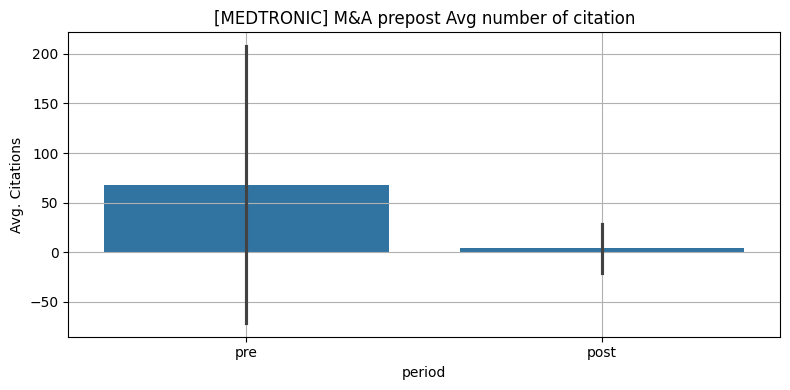

<ipython-input-18-323d14ecc4a9>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=company_df, x='period', y='cross_domain', ci=None)


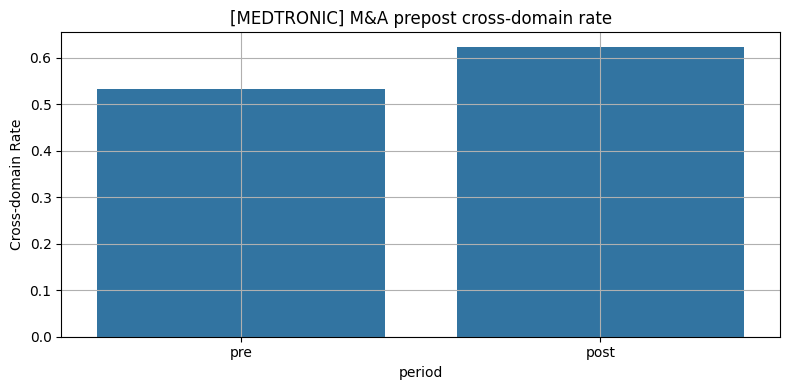

<ipython-input-18-323d14ecc4a9>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=company_df, x='period', y='Cited by Patent Count', ci='sd')


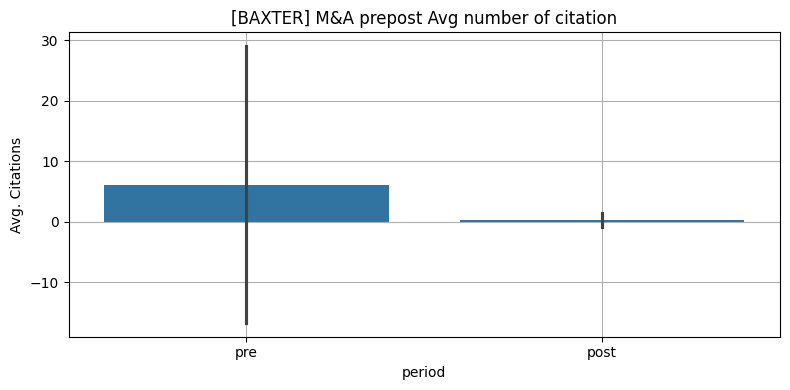

<ipython-input-18-323d14ecc4a9>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=company_df, x='period', y='cross_domain', ci=None)


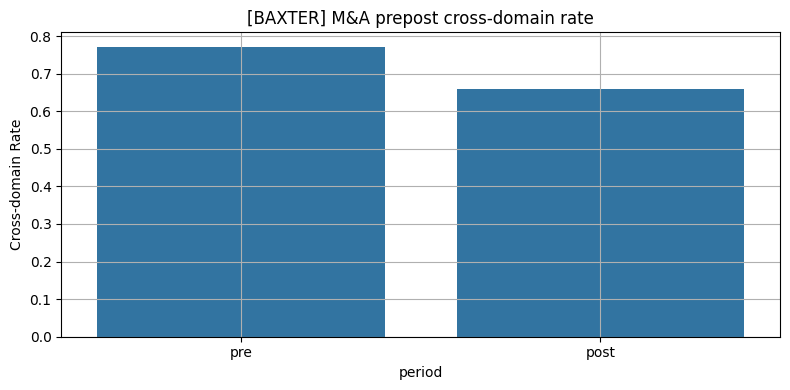

<ipython-input-18-323d14ecc4a9>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=company_df, x='period', y='Cited by Patent Count', ci='sd')


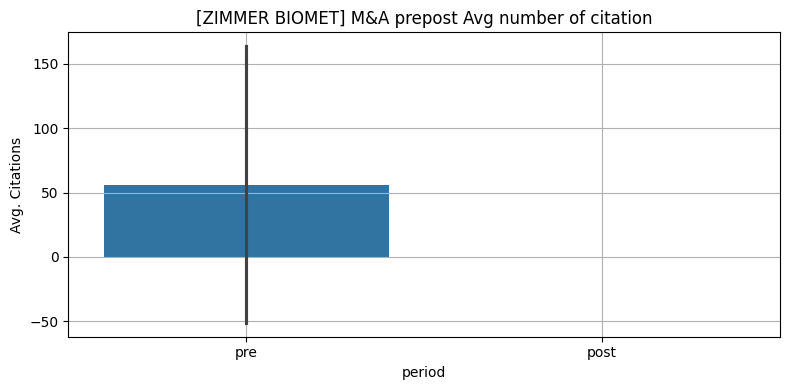

<ipython-input-18-323d14ecc4a9>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=company_df, x='period', y='cross_domain', ci=None)


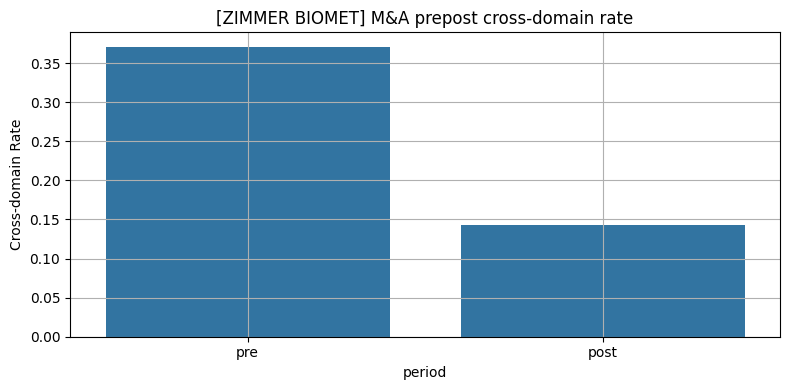

<ipython-input-18-323d14ecc4a9>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=company_df, x='period', y='Cited by Patent Count', ci='sd')


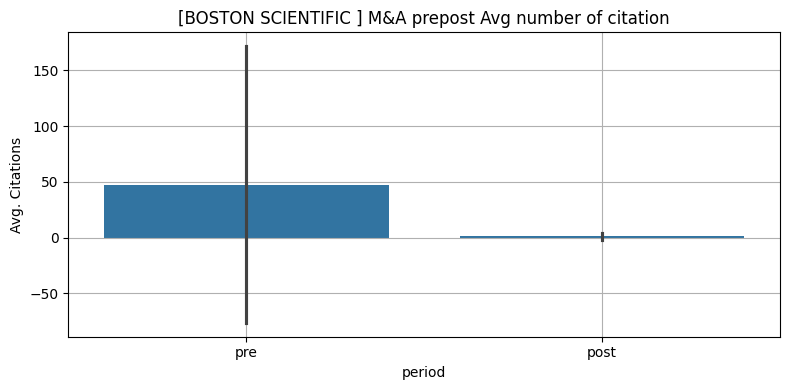

<ipython-input-18-323d14ecc4a9>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=company_df, x='period', y='cross_domain', ci=None)


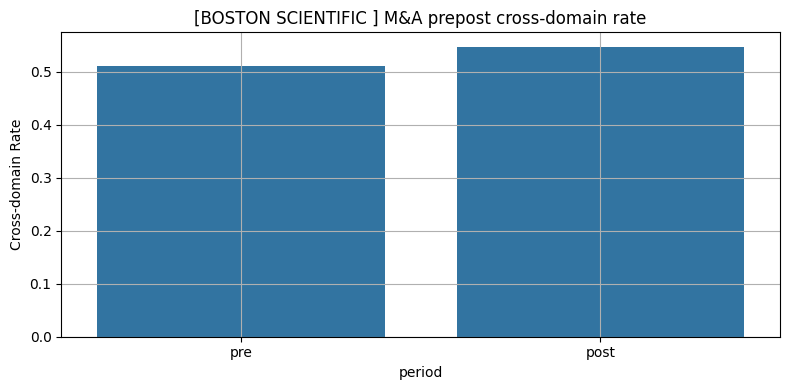

<ipython-input-18-323d14ecc4a9>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=company_df, x='period', y='Cited by Patent Count', ci='sd')


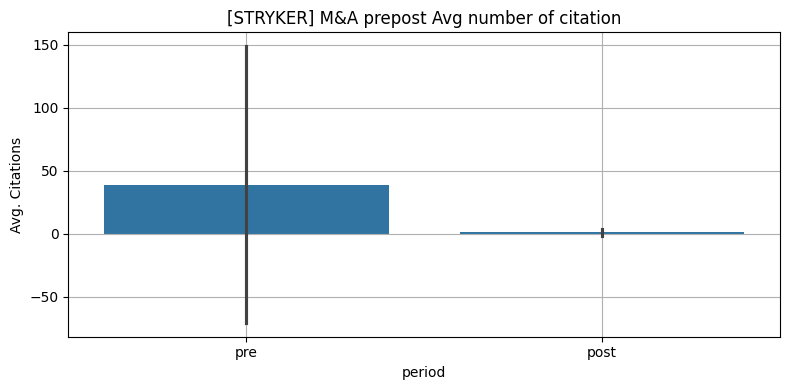

<ipython-input-18-323d14ecc4a9>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=company_df, x='period', y='cross_domain', ci=None)


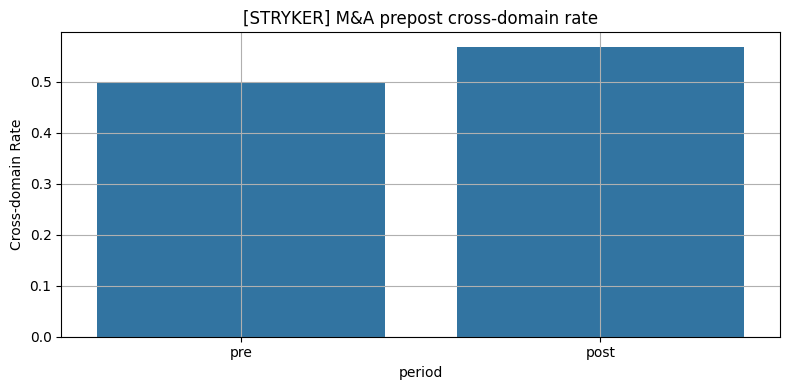

<ipython-input-18-323d14ecc4a9>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=company_df, x='period', y='Cited by Patent Count', ci='sd')


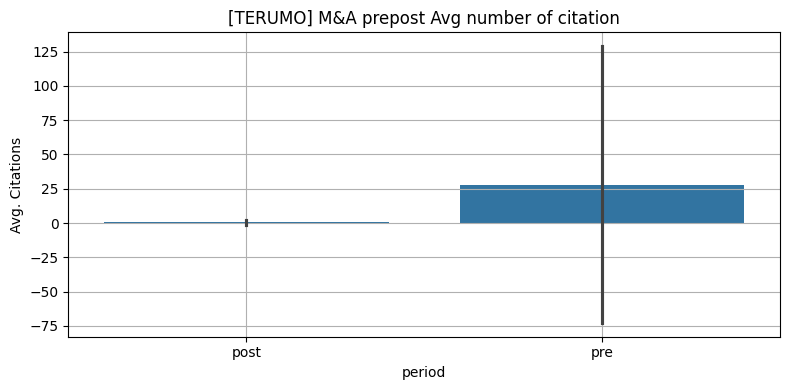

<ipython-input-18-323d14ecc4a9>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=company_df, x='period', y='cross_domain', ci=None)


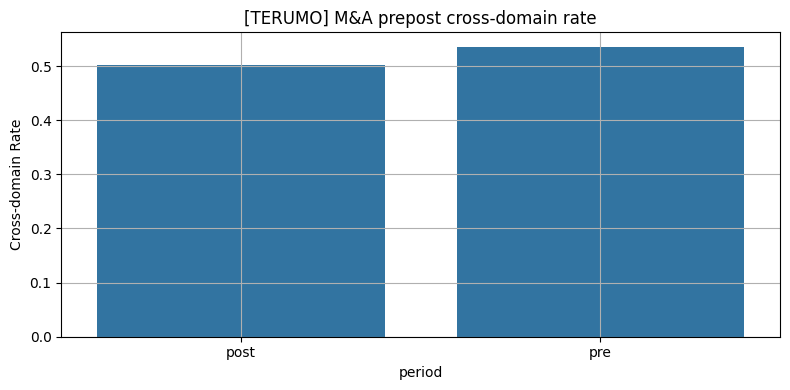

<ipython-input-18-323d14ecc4a9>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=company_df, x='period', y='Cited by Patent Count', ci='sd')


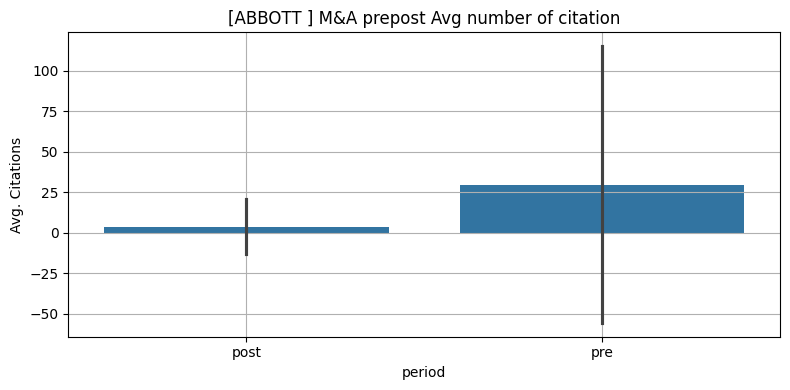

<ipython-input-18-323d14ecc4a9>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=company_df, x='period', y='cross_domain', ci=None)


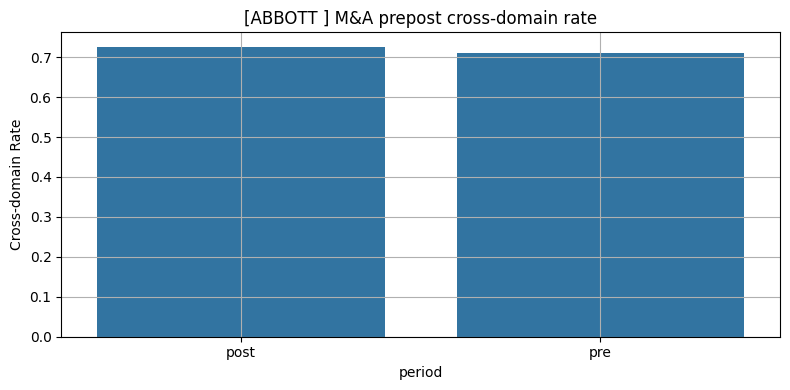

<ipython-input-18-323d14ecc4a9>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=company_df, x='period', y='Cited by Patent Count', ci='sd')


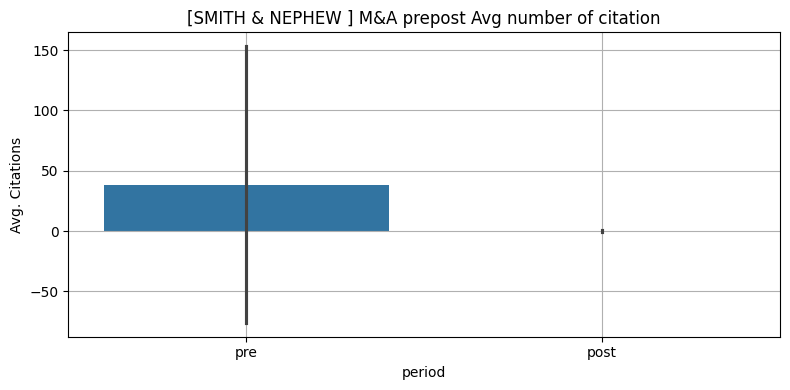

<ipython-input-18-323d14ecc4a9>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=company_df, x='period', y='cross_domain', ci=None)


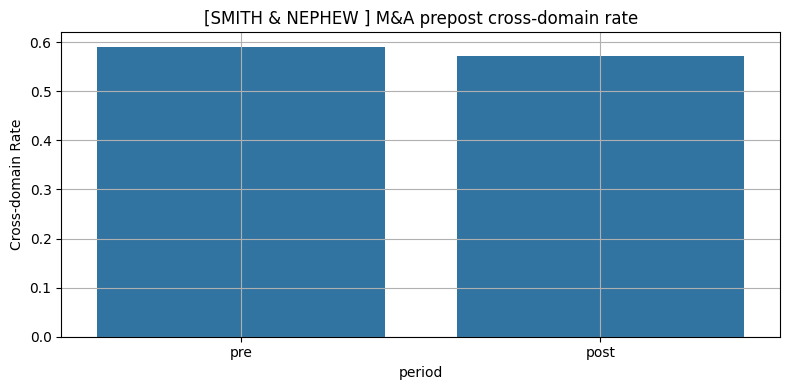

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# cross-domain 컬럼 생성
def is_cross_domain(cpc_string):
    if pd.isna(cpc_string):
        return 0
    codes = str(cpc_string).split(';;')
    prefixes = set(code.strip()[:4] for code in codes if len(code.strip()) >= 4)
    return 1 if len(prefixes) > 1 else 0

df['cross_domain'] = df['CPC Classifications'].apply(is_cross_domain)

# period 컬럼 생성
df['period'] = df.apply(lambda row: 'pre' if row['Publication Year'] < row['M&Aperiod'] else 'post', axis=1)

# 기업 리스트
companies = df['Owners'].unique()

# 기업별 그래프 그리기
for company in companies:
    company_df = df[df['Owners'] == company]

    # 1. 인용 수 변화
    plt.figure(figsize=(8, 4))
    sns.barplot(data=company_df, x='period', y='Cited by Patent Count', ci='sd')
    plt.title(f"[{company}] M&A prepost Avg number of citation")
    plt.ylabel("Avg. Citations")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. cross-domain 비율 변화
    plt.figure(figsize=(8, 4))
    sns.barplot(data=company_df, x='period', y='cross_domain', ci=None)
    plt.title(f"[{company}] M&A prepost cross-domain rate")
    plt.ylabel("Cross-domain Rate")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# 처치군만 필터링
df_t = df[df['group'] == 'T']

# M&A 전/후 cross-domain 특허 수 (successes)
cross_pre = df_t[df_t['period'] == 'pre']['cross_domain'].sum()
cross_post = df_t[df_t['period'] == 'post']['cross_domain'].sum()

# 전체 특허 수 (nobs)
total_pre = df_t[df_t['period'] == 'pre']['cross_domain'].count()
total_post = df_t[df_t['period'] == 'post']['cross_domain'].count()

# Z-test 실행
count = [cross_pre, cross_post]
nobs = [total_pre, total_post]

z_stat, p_value = proportions_ztest(count, nobs)

# 결과 출력
print("=== 처치군 cross-domain 비율 검정 ===")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print("→", "유의미한 차이 있음" if p_value < 0.05 else "통계적으로 유의하지 않음")

=== 처치군 cross-domain 비율 검정 ===
Z-statistic: -17.5969
P-value: 0.0000
→ 유의미한 차이 있음


In [ ]:
# 대조군 필터링
df_c = df[df['group'] == 'C']

cross_pre_c = df_c[df_c['period'] == 'pre']['cross_domain'].sum()
cross_post_c = df_c[df_c['period'] == 'post']['cross_domain'].sum()

total_pre_c = df_c[df_c['period'] == 'pre']['cross_domain'].count()
total_post_c = df_c[df_c['period'] == 'post']['cross_domain'].count()

count_c = [cross_pre_c, cross_post_c]
nobs_c = [total_pre_c, total_post_c]

z_stat_c, p_value_c = proportions_ztest(count_c, nobs_c)

print("\n=== 대조군 cross-domain 비율 검정 ===")
print(f"Z-statistic: {z_stat_c:.4f}")
print(f"P-value: {p_value_c:.4f}")
print("→", "유의미한 차이 있음" if p_value_c < 0.05 else "통계적으로 유의하지 않음")


=== 대조군 cross-domain 비율 검정 ===
Z-statistic: 3.6407
P-value: 0.0003
→ 유의미한 차이 있음
